In [603]:
import json
import numpy as np
import os
import struct
from array import array as pyarray
import seaborn as sns
import matplotlib.pyplot as plt

def load_data(dataset, fraction=1.0, base_folder='data'):
    """
    Loads a dataset and performs a random stratified split into training and
    test partitions.

    Arguments:
        dataset - (string) The name of the dataset to load. One of the
            following:
              'blobs': A linearly separable binary classification problem.
              'mnist-binary': A subset of the MNIST dataset containing only
                  0s and 1s.
              'mnist-multiclass': A subset of the MNIST dataset containing the
                  numbers 0 through 4, inclusive.
              'synthetic': A small custom dataset for exploring properties of
                  gradient descent algorithms.
        fraction - (float) Value between 0.0 and 1.0 representing the fraction
            of data to include in the training set. The remaining data is
            included in the test set. Unused if dataset == 'synthetic'.
        base_folder - (string) absolute path to your 'data' directory. If
            defaults to 'data'.
    Returns:
        train_features - (np.array) An Nxd array of features, where N is the
            number of examples and d is the number of features.
        test_features - (np.array) An Nxd array of features, where M is the
            number of examples and d is the number of features.
        train_targets - (np.array) A 1D array of targets of size N.
        test_targets - (np.array) A 1D array of targets of size M.
    """
    if dataset == 'blobs':
        path = os.path.join(base_folder, 'blobs.json')
        train_features, test_features, train_targets, test_targets = \
            load_json_data(path)
    elif dataset == 'mnist-binary':
        train_features, test_features, train_targets, test_targets = \
            load_mnist_data(2, fraction=fraction, mnist_folder=base_folder)
        train_targets = train_targets * 2 - 1
        test_targets = test_targets * 2 - 1
    elif dataset == 'mnist-multiclass':
        train_features, test_features, train_targets, test_targets = \
            load_mnist_data(5, fraction=fraction, examples_per_class=100,
                            mnist_folder=base_folder)
    elif dataset == 'synthetic':
        path = os.path.join(base_folder,  'synthetic.json')
        train_features, test_features, train_targets, test_targets = \
            load_json_data(path)
    else:
        raise ValueError('Dataset {} not found!'.format(dataset))

    # Normalize the data using feature-independent whitening. Note that the
    # statistics are computed with respect to the training set and applied to
    # both the training and testing sets.
    if dataset != 'synthetic':
        mean = train_features.mean(axis=0, keepdims=True)
        std = train_features.std(axis=0, keepdims=True) + 1e-5
        train_features = (train_features - mean) / std
        if fraction < 1.0:
            test_features = (test_features - mean) / std

    return train_features, test_features, train_targets, test_targets


def load_json_data(path, fraction=None, examples_per_class=None):
    """
    Loads a dataset stored as a JSON file. This will not split your dataset
    into training and testing sets, rather it returns all features and targets
    in `train_features` and `train_targets` and leaves `test_features` and
    `test_targets` as empty numpy arrays. This is done to match the API
    of the other data loaders.

    Args:
        path - (string) Path to json file containing the data
        fraction - (float) Ignored.
        examples_per_class - (int) - Ignored.

    Returns:
        train_features - (np.array) An Nxd array of features, where N is the
            number of examples and d is the number of features.
        test_features - (np.array) An empty 2D numpy array.
        train_targets - (np.array) A 1D array of targets of size N.
        test_targets - (np.array) An empty 1D array.
    """
    with open(path, 'rb') as file:
        data = json.load(file)
    features = np.array(data[0]).astype(float)
    targets = np.array(data[1]).astype(int)

    return features, np.array([[]]), targets, np.array([])


def load_mnist_data(threshold, fraction=1.0, examples_per_class=500, mnist_folder='data'):
    """
    Loads a subset of the MNIST dataset.

    Arguments:
        threshold - (int) One greater than the maximum digit in the selected
            subset. For example to get digits [0, 1, 2] this arg should be 3, or
            to get the digits [0, 1, 2, 3, 4, 5, 6] this arg should be 7.
        fraction - (float) Value between 0.0 and 1.0 representing the fraction
            of data to include in the training set. The remaining data is
            included in the test set. Unused if dataset == 'synthetic'.
        examples_per_class - (int) Number of examples to retrieve in each
            class.
        mnist_folder - (string) Path to folder contain MNIST binary files.

    Returns:
        train_features - (np.array) An Nxd array of features, where N is the
            number of examples and d is the number of features.
        test_features - (np.array) An Nxd array of features, where M is the
            number of examples and d is the number of features.
        train_targets - (np.array) A 1D array of targets of size N.
        test_targets - (np.array) A 1D array of targets of size M.
    """
    assert 0.0 <= fraction <= 1.0, 'Whoopsies! Incorrect value for fraction :P'

    train_examples = int(examples_per_class * fraction)
    if train_examples == 0:
        train_features, train_targets = np.array([[]]), np.array([])
    else:
        train_features, train_targets = _load_mnist(
            dataset='training', digits=range(threshold), path=mnist_folder)
        train_features, train_targets = stratified_subset(
            train_features, train_targets, train_examples)
        train_features = train_features.reshape((len(train_features), -1))

    test_examples = examples_per_class - train_examples
    if test_examples == 0:
        test_features, test_targets = np.array([[]]), np.array([])
    else:
        test_features, test_targets = _load_mnist(
            dataset='testing', digits=range(threshold), path=mnist_folder)
        test_features, test_targets = stratified_subset(
            test_features, test_targets, test_examples)
        test_features = test_features.reshape((len(test_features), -1))

    return train_features, test_features, train_targets, test_targets


def _load_mnist(path, dataset="training", digits=None, asbytes=False,
                selection=None, return_labels=True, return_indices=False):
    """
    Loads MNIST files into a 3D numpy array. Does not automatically download
    the dataset. You must download the dataset manually. The data can be
    downloaded from http://yann.lecun.com/exdb/mnist/.

    Examples:
        1) Assuming that you have downloaded the MNIST database in a directory
        called 'data', this will load all images and labels from the training
        set:

            images, labels = _load_mnist('training')

        2) And this will load 100 sevens from the test partition:

            sevens = _load_mnist('testing', digits=[7], selection=slice(0, 100),
                                return_labels=False)

    Arguments:
        path - (str) Path to your MNIST datafiles.
        dataset - (str) Either "training" or "testing". The data partition to
            load.
        digits - (list or None) A list of integers specifying the digits to
            load. If None, the entire database is loaded.
        asbytes - (bool) If True, returns data as ``numpy.uint8`` in [0, 255]
            as opposed to ``numpy.float64`` in [0.0, 1.0].
        selection - (slice) Using a `slice` object, specify what subset of the
            dataset to load. An example is ``slice(0, 20, 2)``, which would
            load every other digit until--but not including--the twentieth.
        return_labels - (bool) Specify whether or not labels should be
            returned. This is also a speed performance if digits are not
            specified, since then the labels file does not need to be read at
            all.
        return_indicies - (bool) Specify whether or not to return the MNIST
            indices that were fetched. This is valuable only if digits is
            specified, because in that case it can be valuable to know how far
            in the database it reached.
    Returns:
        images - (np.array) Image data of shape ``(N, rows, cols)``, where
            ``N`` is the number of images. If neither labels nor indices are
            returned, then this is returned directly, and not inside a 1-sized
            tuple.
        labels - (np.array) Array of size ``N`` describing the labels.
            Returned only if ``return_labels`` is `True`, which is default.
        indices - (np.array) The indices in the database that were returned.
    """

    # The files are assumed to have these names and should be found in 'path'
    files = {
        'training': ('train-images-idx3-ubyte', 'train-labels-idx1-ubyte'),
        'testing': ('t10k-images-idx3-ubyte', 't10k-labels-idx1-ubyte'),
    }

    try:
        images_fname = os.path.join(path, files[dataset][0])
        labels_fname = os.path.join(path, files[dataset][1])
    except KeyError:
        raise ValueError("Data set must be 'testing' or 'training'")

    # We can skip the labels file only if digits aren't specified and labels
    # aren't asked for
    if return_labels or digits is not None:
        flbl = open(labels_fname, 'rb')
        magic_nr, size = struct.unpack(">II", flbl.read(8))
        labels_raw = pyarray("b", flbl.read())
        flbl.close()

    fimg = open(images_fname, 'rb')
    magic_nr, size, rows, cols = struct.unpack(">IIII", fimg.read(16))
    images_raw = pyarray("B", fimg.read())
    fimg.close()

    if digits:
        indices = [k for k in range(size) if labels_raw[k] in digits]
    else:
        indices = range(size)

    if selection:
        indices = indices[selection]

    images = np.zeros((len(indices), rows, cols), dtype=np.uint8)

    if return_labels:
        labels = np.zeros((len(indices)), dtype=np.int8)
    for i in range(len(indices)):
        images[i] = np.array(images_raw[indices[i] * rows * cols:(indices[i] + 1) * rows * cols]).reshape((rows, cols))
        if return_labels:
            labels[i] = labels_raw[indices[i]]

    if not asbytes:
        images = images.astype(float)/255.0

    ret = (images,)
    if return_labels:
        ret += (labels,)
    if return_indices:
        ret += (indices,)

    if len(ret) == 1:
        return ret[0]  # Don't return a tuple of one

    return ret


def stratified_subset(features, targets, examples_per_class):
    """
    Evenly sample the dataset across unique classes. Requires each unique class
    to have at least examples_per_class examples.

    Arguments:
        features - (np.array) An Nxd array of features, where N is the
            number of examples and d is the number of features.
        targets - (np.array) A 1D array of targets of size N.
        examples_per_class - (int) The number of examples to take in each
            unique class.
    Returns:
        train_features - (np.array) An Nxd array of features, where N is the
            number of examples and d is the number of features.
        test_features - (np.array) An Nxd array of features, where M is the
            number of examples and d is the number of features.
        train_targets - (np.array) A 1D array of targets of size N.
        test_targets - (np.array) A 1D array of targets of size M.
    """
    idxs = np.array([False] * len(features))
    for target in np.unique(targets):
        idxs[np.where(targets == target)[0][:examples_per_class]] = True
    return features[idxs], targets[idxs]

import numpy as np

class Regularization:
    """
    Abstract base class for regularization terms in gradient descent.

    *** THIS IS A BASE CLASS: YOU DO NOT NEED TO IMPLEMENT THIS ***

    Arguments:
        reg_param - (float) The hyperparameter that controls the amount of
            regularization to perform. Must be non-negative.
    """

    def __init__(self, reg_param=0.05):
        self.reg_param = reg_param

    def forward(self, w):
        """
        Implements the forward pass through the regularization term.

        *** THIS IS A BASE CLASS: YOU DO NOT NEED TO IMPLEMENT THIS ***

        Arguments:
            w - (np.array) A 1D array of parameters of length d+1. The current
                parameters learned by the model. The +1 refers to the bias
                term.
        Returns:
            regularization_term - (float) The value of the regularization term
                evaluated at w.
        """
        pass

    def backward(self, w):
        """
        Implements the backward pass through the regularization term.

        *** THIS IS A BASE CLASS: YOU DO NOT NEED TO IMPLEMENT THIS ***

        Arguments:
            w - (np.array) A 1D array of parameters of length d+1. The current
                parameters learned by the model. The +1 refers to the bias
                term.
        Returns:
            gradient_term - (np.array) A numpy array of length d+1. The
                gradient of the regularization term evaluated at w.
        """
        pass


class L1Regularization(Regularization):
    """
    L1 Regularization for gradient descent.
    """

    def forward(self, w):
        """
        Implements the forward pass through the regularization term. For L1,
        this is the L1-norm of the model parameters weighted by the
        regularization parameter. Note that the bias (the last value in w)
        should NOT be included in regularization.

        Arguments:
            w - (np.array) A 1D array of parameters of length d+1. The current
                parameters learned by the model. The +1 refers to the bias
                term.
        Returns:
            regularization_term - (float) The value of the regularization term
                evaluated at w.
        """
        return self.reg_param * sum(np.abs(w[:-1]))

    def backward(self, w):
        """
        Implements the backward pass through the regularization term. The
        backward pass is the gradient of the forward pass with respect to the
        model parameters.

        Arguments:
            w - (np.array) A 1D array of parameters of length d+1. The current
                parameters learned by the model. The +1 refers to the bias
                term.
        Returns:
            gradient_term - (np.array) A numpy array of length d+1. The
                gradient of the regularization term evaluated at w.
        """

        w = w.flatten()

        gradient = self.reg_param * np.array(list(map(lambda el: -1 if el < 0 else( 0 if el == 0 else 1  ), w)))
        gradient[-1] = 0 # the bias is considered a constant, because it is not regularized

        return gradient


class L2Regularization(Regularization):
    """
    L2 Regularization for gradient descent.
    """

    def forward(self, w):
        """
        Implements the forward pass through the regularization term. For L2,
        this is half the squared L2-norm of the model parameters weighted by
        the regularization parameter. Note that the bias (the last value in w)
        should NOT be included in regularization.

        Arguments:
            w - (np.array) A 1D array of parameters of length d+1. The current
                parameters learned by the model. The +1 refers to the bias
                term.
        Returns:
            regularization_term - (float) The value of the regularization term
                evaluated at w.
        """

        return self.reg_param * .5 * sum(np.abs(w[:-1])**2)

    def backward(self, w):
        """
        Implements the backward pass through the regularization term. The
        backward pass is the gradient of the forward pass with respect to the
        model parameters.

        Arguments:
            w - (np.array) A 1D array of parameters of length d+1. The current
                parameters learned by the model. The +1 refers to the bias
                term.
        Returns:
            gradient_term - (np.array) A numpy array of length d+1. The
                gradient of the regularization term evaluated at w.
        """
        gradient = self.reg_param * w
        gradient[-1] = 0 # the bias is considered a constant, because it is not regularized

        return gradient

import numpy as np


class Loss:
    """
    An abstract base class for a loss function that computes both the prescribed
    loss function (the forward pass) as well as its gradient (the backward
    pass).

    *** THIS IS A BASE CLASS: YOU DO NOT NEED TO IMPLEMENT THIS ***

    Arguments:
        regularization - (`Regularization` or None) The type of regularization to
            perform. Either a derived class of `Regularization` or None. If None,
            no regularization is performed.
    """

    def __init__(self, regularization=None):
        self.regularization = regularization

    def forward(self, X, w, y):
        """
        Computes the forward pass through the loss function. If
        self.regularization is not None, also adds the forward pass of the
        regularization term to the loss.

        *** THIS IS A BASE CLASS: YOU DO NOT NEED TO IMPLEMENT THIS ***

        Arguments:
            X - (np.array) An Nx(d+1) array of features, where N is the number
                of examples and d is the number of features. The +1 refers to
                the bias term.
            w - (np.array) A 1D array of parameters of length d+1. The current
                parameters learned by the model. The +1 refers to the bias
                term.
            y - (np.array) A 1D array of targets of length N.
        Returns:
            loss - (float) The calculated loss normalized by the number of
                examples, N.
        """
        pass

    def backward(self, X, w, y):
        """
        Computes the gradient of the loss function with respect to the model
        parameters. If self.regularization is not None, also adds the backward
        pass of the regularization term to the loss.

        *** THIS IS A BASE CLASS: YOU DO NOT NEED TO IMPLEMENT THIS ***

        Arguments:
            X - (np.array) An Nx(d+1) array of features, where N is the number
                of examples and d is the number of features. The +1 refers to
                the bias term.
            w - (np.array) A 1D array of parameters of length d+1. The current
                parameters learned by the model. The +1 refers to the bias
                term.
            y - (np.array) A 1D array of targets of length N.
        Returns:
            gradient - (np.array) The (d+1)-dimensional gradient of the loss
                function with respect to the model parameters. The +1 refers to
                the bias term.
        """
        pass


class SquaredLoss(Loss):
    """
    The squared loss function.
    """

    def forward(self, X, w, y):
        """
        Computes the forward pass through the loss function. If
        self.regularization is not None, also adds the forward pass of the
        regularization term to the loss. The squared loss for a single example
        is given as follows:

        L_s(x, y; w) = (1/2) (y - w^T x)^2

        The squared loss over a dataset of N points is the average of this
        expression over all N examples.

        Arguments:
            X - (np.array) An Nx(d+1) array of features, where N is the number
                of examples and d is the number of features. The +1 refers to
                the bias term.
            w - (np.array) A 1D array of parameters of length d+1. The current
                parameters learned by the model. The +1 refers to the bias
                term.
            y - (np.array) A 1D array of targets of length N.
        Returns:
            loss - (float) The calculated loss normalized by the number of
                examples, N.
        """

        N = X.shape[0]

        if self.regularization:
            return np.sum(((y - X.dot(w))**2)/(2*N), dtype=float)+self.regularization.forward(w) 
        else:
            return np.sum(((y - X.dot(w))**2)/(2*N), dtype=float)

    def backward(self, X, w, y):
        """
        Computes the gradient of the loss function with respect to the model
        parameters. If self.regularization is not None, also adds the backward
        pass of the regularization term to the loss.

        Arguments:
            X - (np.array) An Nx(d+1) array of features, where N is the number
                of examples and d is the number of features. The +1 refers to
                the bias term.
            w - (np.array) A 1D array of parameters of length d+1. The current
                parameters learned by the model. The +1 refers to the bias
                term.
            y - (np.array) A 1D array of targets of length N.
        Returns:
            gradient - (np.array) The (d+1)-dimensional gradient of the loss
                function with respect to the model parameters. The +1 refers to
                the bias term.
        """
        N = X.shape[0]

        if self.regularization:
            return -X.T.dot((y-X.dot(w.T)).reshape(-1,1)).T / N + self.regularization.backward(w)
        else:
            return -X.T.dot((y-X.dot(w.T)).reshape(-1,1)).T / N


class HingeLoss(Loss):
    """
    The hinge loss function.

    https://en.wikipedia.org/wiki/Hinge_loss
    """

    def forward(self, X, w, y):
        """
        Computes the forward pass through the loss function. If
        self.regularization is not None, also adds the forward pass of the
        regularization term to the loss. The hinge loss for a single example
        is given as follows:

        L_h(x, y; w) = max(0, 1 - y w^T x)

        The hinge loss over a dataset of N points is the average of this
        expression over all N examples.

        Arguments:
            X - (np.array) An Nx(d+1) array of features, where N is the number
                of examples and d is the number of features. The +1 refers to
                the bias term.
            w - (np.array) A 1D array of parameters of length d+1. The current
                parameters learned by the model. The +1 refers to the bias
                term.
            y - (np.array) A 1D array of targets of length N.
        Returns:
            loss - (float) The calculated loss normalized by the number of
                examples, N.
        """
        N = X.shape[0]

        result = np.zeros(N)
        for ii in range(N):
            result[ii] = max((0, 1-y[ii]*(X.dot(w.reshape(-1,1)))[ii]))



        if self.regularization:
            return sum(result) / N + self.regularization.forward(w)
        else:
            return sum(result) / N

    def backward(self, X, w, y):
        """
        Computes the gradient of the loss function with respect to the model
        parameters. If self.regularization is not None, also adds the backward
        pass of the regularization term to the loss.

        Arguments:
            X - (np.array) An Nx(d+1) array of features, where N is the number
                of examples and d is the number of features. The +1 refers to
                the bias term.
            w - (np.array) A 1D array of parameters of length d+1. The current
                parameters learned by the model. The +1 refers to the bias
                term.
            y - (np.array) A 1D array of targets of length N.
        Returns:
            gradient - (np.array) The (d+1)-dimensional gradient of the loss
                function with respect to the model parameters. The +1 refers to
                the bias term.
        """
        N = X.shape[0]
        gradient = np.zeros(X.shape[1])

        result = np.zeros(N)
        for ii in range(N):
            if 1-y[ii]*(X.dot(w.reshape(-1,1)))[ii] > 0:
                gradient -= y[ii] * X[ii] 
            else:
                gradient += np.zeros(X.shape[1])

        if self.regularization:
            return gradient / N + self.regularization.backward(w)
        else:
            return gradient / N


class ZeroOneLoss(Loss):
    """
    The 0-1 loss function.

    The loss is 0 iff w^T x == y, else the loss is 1.

    *** YOU DO NOT NEED TO IMPLEMENT THIS ***
    """

    def forward(self, X, w, y):
        """
        Computes the forward pass through the loss function. If
        self.regularization is not None, also adds the forward pass of the
        regularization term to the loss. The squared loss for a single example
        is given as follows:

        L_0-1(x, y; w) = {0 iff w^T x == y, else 1}

        The squared loss over a dataset of N points is the average of this
        expression over all N examples.

        Arguments:
            X - (np.array) An Nx(d+1) array of features, where N is the number
                of examples and d is the number of features. The +1 refers to
                the bias term.
            w - (np.array) A 1D array of parameters of length d+1. The current
                parameters learned by the model. The +1 refers to the bias
                term.
            y - (np.array) A 1D array of targets of length N.
        Returns:
            loss - (float) The average loss.
        """
        predictions = (X @ w > 0.0).astype(int) * 2 - 1
        loss = np.sum((predictions != y).astype(float)) / len(X)
        if self.regularization:
            loss += self.regularization.forward(w)
        return loss

    def backward(self, X, w, y):
        """
        Computes the gradient of the loss function with respect to the model
        parameters. If self.regularization is not None, also adds the backward
        pass of the regularization term to the loss.

        Arguments:
            X - (np.array) An Nx(d+1) array of features, where N is the number
                of examples and d is the number of features. The +1 refers to
                the bias term.
            w - (np.array) A 1D array of parameters of length d+1. The current
                parameters learned by the model. The +1 refers to the bias
                term.
            y - (np.array) A 1D array of targets of length N.
        Returns:
            gradient - (np.array) The (d+1)-dimensional gradient of the loss
                function with respect to the model parameters. The +1 refers to
                the bias term.
        """
        # This function purposefully left blank
        raise ValueError('No need to use this function for the homework :p')


class GradientDescent:
    """
    This is a linear classifier similar to the one you implemented in the
    linear regressor homework. This is the classification via regression
    case. The goal here is to learn some hyperplane, y = w^T x + b, such that
    when features, x, are processed by our model (w and b), the result is
    some value y. If y is in [0.0, +inf), the predicted classification label
    is +1 and if y is in (-inf, 0.0) the predicted classification label is
    -1.

    The catch here is that we will not be using the closed form solution,
    rather, we will be using gradient descent. In your fit function you
    will determine a loss and update your model (w and b) using gradient
    descent. More details below.

    Arguments:
        loss - (string) The loss function to use. Either 'hinge' or 'squared'.
        regularization - (string or None) The type of regularization to use.
            One of 'l1', 'l2', or None. See regularization.py for more details.
        learning_rate - (float) The size of each gradient descent update step.
        reg_param - (float) The hyperparameter that controls the amount of
            regularization to perform. Must be non-negative.
    """
    def __init__(self, loss, regularization=None,
                 learning_rate=0.01, reg_param=0.05):
        self.learning_rate = learning_rate

        # Select regularizer
        if regularization == 'l1':
            regularizer = L1Regularization(reg_param)
        elif regularization == 'l2':
            regularizer = L2Regularization(reg_param)
        elif regularization is None:
            regularizer = None
        else:
            raise ValueError(
                'Regularizer {} is not defined'.format(regularization))

        # Select loss function
        if loss == 'hinge':
            self.loss = HingeLoss(regularizer)
        elif loss == 'squared':
            self.loss = SquaredLoss(regularizer)
        else:
            raise ValueError('Loss function {} is not defined'.format(loss))

        self.model = None

    def fit(self, features, targets, batch_size=None, max_iter=1000):
        """
        Fits a gradient descent learner to the features and targets. The
        pseudocode for the fitting algorithm is as follow:
          - Initialize the model parameters to uniform random values in the
            interval [-0.1, +0.1].
          - While not converged:
            - Compute the gradient of the loss with respect to the current
              batch.
            - Update the model parameters by moving them in the direction
              opposite to the current gradient. Use the learning rate as the
              step size.
        For the convergence criteria, compute the loss over all examples. If
        this loss changes by less than 1e-4 during an update, assume that the
        model has converged. If this convergence criteria has not been met
        after max_iter iterations, also assume convergence and terminate.

        You should include a bias term by APPENDING a column of 1s to your
        feature matrix. The bias term is then the last value in self.model.

        Arguments:
            features - (np.array) An Nxd array of features, where N is the
                number of examples and d is the number of features.
            targets - (np.array) A 1D array of targets of length N.
            batch_size - (int or None) The number of examples used in each
                iteration. If None, use all of the examples in each update.
            max_iter - (int) The maximum number of updates to perform.
        Modifies:
            self.model - (np.array) A 1D array of model parameters of length
                d+1. The +1 refers to the bias term.
        """

        # Adding bias term
        features = np.append(features, np.ones(features.shape[0]).reshape(-1,1),  axis=1)

        # Initializing model parameters in interval [-.1, +.1]
        self.model = (np.random.rand(features.shape[1])-.5)/5

        # Tolerance for convergence
        tolerance = 1e-4
        
        # Accuracies
        accuracies = []
        losses = []
        
        # Instantiating indices of feature data
        all_indices = list(range(len(features)))
        np.random.shuffle(all_indices)

        for iteration in range(max_iter):
            
            if iteration % 100 == 0:
                print('ITERATION', iteration)
                
            if batch_size:
                
                # Case of STOCHASTIC GRADIENT DESCENT
                if batch_size == 1:
                    
                    # If we've run out of indices then we've finished an epoch and we need to reset the indices for another epoch
                    if len(all_indices) == 0:
                        all_indices = list(range(len(features)))
                        np.random.shuffle(all_indices)
                    
                    # Take an index
                    indices = all_indices.pop()
                    # Use it for training
                    batch_features = features[indices].reshape(1, -1)
                    batch_targets = targets[indices].flatten()#.reshape(-1, 1)
                    
                
                # Case of MINI BATCH GRADIENT DESCENT
                else:
                    indices = np.random.choice(range(features.shape[0]), batch_size)
                    batch_features = features[indices]
                    batch_targets = targets[indices]
            else:
                batch_features = features
                batch_targets = targets

            
            # Calculating Results for each EPOCH
#             if iteration % 1000 == 0:
            # Calculating current loss
            current_loss = self.loss.forward(features, self.model, targets)

            # Calculating current accuracy
#             current_predictions = self.predict(features)

            # Record accuracy & loss
#             losses.append(current_loss)
#             accuracies.append(accuracy(targets, current_predictions))
            
            
            
            # Update model weights
#             print('BATCH_FEATURES.SHAPE', batch_features.shape)
#             print('BATCH_TARGETS.SHAPE', batch_targets.shape)
            self.model = self.model - self.learning_rate * self.loss.backward(batch_features, self.model, batch_targets)
            self.model = self.model.flatten()

#             if iteration % 1000 == 0:
            # Calculating new_loss
            new_loss = self.loss.forward(features, self.model, targets)

            # Checking for convergence
            if np.abs(current_loss-new_loss) < tolerance:
                break
                
#         return losses, accuracies

    def predict(self, features):
        """
        Predicts the class labels of each example in features. Model output
        values at and above 0 are predicted to have label +1. Non-positive
        output values are predicted to have label -1.

        NOTE: your predict function should make use of your confidence
        function (see below).

        Arguments:
            features - (np.array) A Nxd array of features, where N is the
                number of examples and d is the number of features.
        Returns:
            predictions - (np.array) A 1D array of predictions of length N,
                where index d corresponds to the prediction of row N of
                features.
        """

        confidences = self.confidence(features)
        return np.where(confidences >= 0, 1, -1).reshape(1,-1).flatten()

    def confidence(self, features):
        """
        Returns the raw model output of the prediction. In other words, rather
        than predicting +1 for values above 0 and -1 for other values, this
        function returns the original, unquantized value.

        Arguments:
            features - (np.array) A Nxd array of features, where N is the
                number of examples and d is the number of features.
        Returns:
            confidence - (np.array) A 1D array of confidence values of length
                N, where index d corresponds to the confidence of row N of
                features.
        """
        # Adding bias term
        features = np.append(features, np.ones(features.shape[0]).reshape(-1,1),  axis=1) # <------------------------------------------ MODIFICATION

        return features.dot(self.model.T)




class MultiClassGradientDescent:
    """
    Implements linear gradient descent for multiclass classification. Uses
    One-vs-All (OVA) classification for aggregating binary classification
    results to the multiclass setting.

    Arguments:
        loss - (string) The loss function to use. One of 'hinge' or 'squared'.
        regularization - (string or None) The type of regularization to use.
            One of 'l1', 'l2', or None. See regularization.py for more details.
        learning_rate - (float) The size of each gradient descent update step.
        reg_param - (float) The hyperparameter that controls the amount of
            regularization to perform. Must be non-negative.
    """

    def __init__(self, loss, regularization=None,
                 learning_rate=0.01, reg_param=0.05):
        self.loss = loss
        self.regularization = regularization
        self.learning_rate = learning_rate
        self.reg_param = reg_param

        self.model = []
        self.classes = None

    def fit(self, features, targets, batch_size=None, max_iter=1000):
        """
        Fits a multiclass gradient descent learner to the features and targets
        by using One-vs-All classification. In other words, for each of the c
        output classes, train a GradientDescent classifier to determine whether
        each example does or does not belong to that class.

        Store your c GradientDescent classifiers in the list self.model. Index
        c of self.model should correspond to the binary classifier trained to
        predict whether examples do or do not belong to class c.

        Arguments:
            features - (np.array) An Nxd array of features, where N is the
                number of examples and d is the number of features.
            targets - (np.array) A 1D array of targets of size N. Contains c
                unique values (the possible class labels).
            batch_size - (int or None) The number of examples used in each
                iteration. If None, use all of the examples in each update.
            max_iter - (int) The maximum number of updates to perform.
        Modifies:
            self.model - (list) A list of c GradientDescent objects. The models
                trained to perform OVA classification for each class.
            self.classes - (np.array) A numpy array of the unique target
                values. Required to associate a model index with a target value
                in predict.
        """
        self.classes = np.unique(targets)

        for unique_class in self.classes:
            one_vs_all_targets = np.where(targets == unique_class, 1, -1)
            new_model = GradientDescent(self.loss, self.regularization, self.learning_rate, self.reg_param)
            new_model.fit(features, one_vs_all_targets, batch_size, max_iter)
            self.model.append(new_model)

    def predict(self, features):
        """
        Predicts the class labels of each example in features using OVA
        aggregation. In other words, predict as the output class the class that
        receives the highest confidence score from your c GradientDescent
        classifiers. Predictions should be in the form of integers that
        correspond to the index of the predicted class.

        Arguments:
            features - (np.array) A Nxd array of features, where N is the
                number of examples and d is the number of features.
        Returns:
            predictions - (np.array) A 1D array of predictions of length N,
                where index d corresponds to the prediction of row N of
                features.
        """
        raw_predictions = np.zeros((features.shape[0], len(self.classes)))

        for ii in range(len(self.classes)):
            raw_predictions[:,ii] = self.model[ii].confidence(features)

        index_predictions = np.argmax(raw_predictions, axis=1)

        return np.array([self.classes[ii] for ii in index_predictions])
    
    
def accuracy(ground_truth, predictions):
    """
    Reports the classification accuracy.

    Arguments:
        ground_truth - (np.array) A 1D numpy array of length N. The true class
            labels.
        predictions - (np.array) A 1D numpy array of length N. The class labels
            predicted by the model.
    Returns:
        accuracy - (float) The accuracy of the predictions.
    """
    return np.mean(ground_truth == predictions)


def confusion_matrix(ground_truth, predictions):
    """
    Reports the classification accuracy.

    Arguments:
        ground_truth - (np.array) A 1D numpy array of length N. The true class
            labels.
        predictions - (np.array) A 1D numpy array of length N. The class labels
            predicted by the model.
    Returns:
        confusion_matrix - (np.array) The confusion matrix. A CxC numpy array,
            where C is the number of unique classes. Index i, j is the number
            of times an example belonging to class i was predicted to belong
            to class j.
    """
    classes = np.unique(ground_truth)
    confusion = np.zeros((len(classes), len(classes)))
    for i, prediction in enumerate(predictions):
        confusion[ground_truth[i], prediction] += 1
    return confusion





# Q4 - a

In [604]:
train_features, test_features, train_targets, test_targets = load_data('mnist-binary', fraction=1)

In [605]:
print(train_features.shape)
print(train_targets.shape)

(1000, 784)
(1000,)


In [606]:
loss_func = 'squared'
reg = 'l1'
lr = 1e-5

gd_l1 = GradientDescent(loss=loss_func, regularization=reg, learning_rate=lr)

In [607]:
loss_func = 'squared'
reg = 'l2'

gd_l2 = GradientDescent(loss=loss_func, regularization=reg, learning_rate=lr)

In [608]:
gd_l1.fit(train_features, train_targets, max_iter=2000)

ITERATION 0
ITERATION 100
ITERATION 200
ITERATION 300
ITERATION 400
ITERATION 500
ITERATION 600
ITERATION 700
ITERATION 800
ITERATION 900
ITERATION 1000
ITERATION 1100
ITERATION 1200
ITERATION 1300
ITERATION 1400
ITERATION 1500
ITERATION 1600
ITERATION 1700
ITERATION 1800
ITERATION 1900


In [611]:

sum(np.where(gd_l1.model < epsilon, 0, 1))

407

In [612]:
epsilon = .001
loss_func = 'squared'
reg = 'l1'
lr = 1e-5

non_zero_l1 = []
non_zero_l2 = []
lambdas = [1e-3, 1e-2, 1e-1, 1, 10, 100]

for lambda_ in lambdas:
    gd_l1 = GradientDescent(loss=loss_func, regularization=reg, learning_rate=lr, reg_param=lambda_)
    gd_l2 = GradientDescent(loss=loss_func, regularization=reg, learning_rate=lr, reg_param=lambda_)
    
    gd_l1.fit(train_features, train_targets, max_iter=2000)
    gd_l2.fit(train_features, train_targets, max_iter=2000)

    non_zero_l1.append(sum(np.where(gd_l1.model < epsilon, 0, 1)))
    non_zero_l2.append(sum(np.where(gd_l2.model < epsilon, 0, 1)))


ITERATION 0
ITERATION 100
ITERATION 200
ITERATION 300
ITERATION 400
ITERATION 500
ITERATION 600
ITERATION 700
ITERATION 800
ITERATION 900
ITERATION 1000
ITERATION 1100
ITERATION 1200
ITERATION 1300
ITERATION 1400
ITERATION 1500
ITERATION 1600
ITERATION 1700
ITERATION 1800
ITERATION 1900
ITERATION 0
ITERATION 100
ITERATION 200
ITERATION 300
ITERATION 400
ITERATION 500
ITERATION 600
ITERATION 700
ITERATION 800
ITERATION 900
ITERATION 1000
ITERATION 1100
ITERATION 1200
ITERATION 1300
ITERATION 1400
ITERATION 0
ITERATION 100
ITERATION 200
ITERATION 300
ITERATION 400
ITERATION 500
ITERATION 600
ITERATION 700
ITERATION 800
ITERATION 900
ITERATION 1000
ITERATION 1100
ITERATION 1200
ITERATION 1300
ITERATION 1400
ITERATION 1500
ITERATION 1600
ITERATION 1700
ITERATION 1800
ITERATION 1900
ITERATION 0
ITERATION 100
ITERATION 200
ITERATION 300
ITERATION 400
ITERATION 500
ITERATION 600
ITERATION 700
ITERATION 800
ITERATION 900
ITERATION 1000
ITERATION 1100
ITERATION 1200
ITERATION 1300
ITERATION 140

In [613]:
non_zero_l1

[391, 389, 373, 318, 0, 0]

In [614]:
non_zero_l2

[368, 386, 387, 297, 7, 1]

In [619]:
np.log10(np.array(lambdas))

array([-3., -2., -1.,  0.,  1.,  2.])

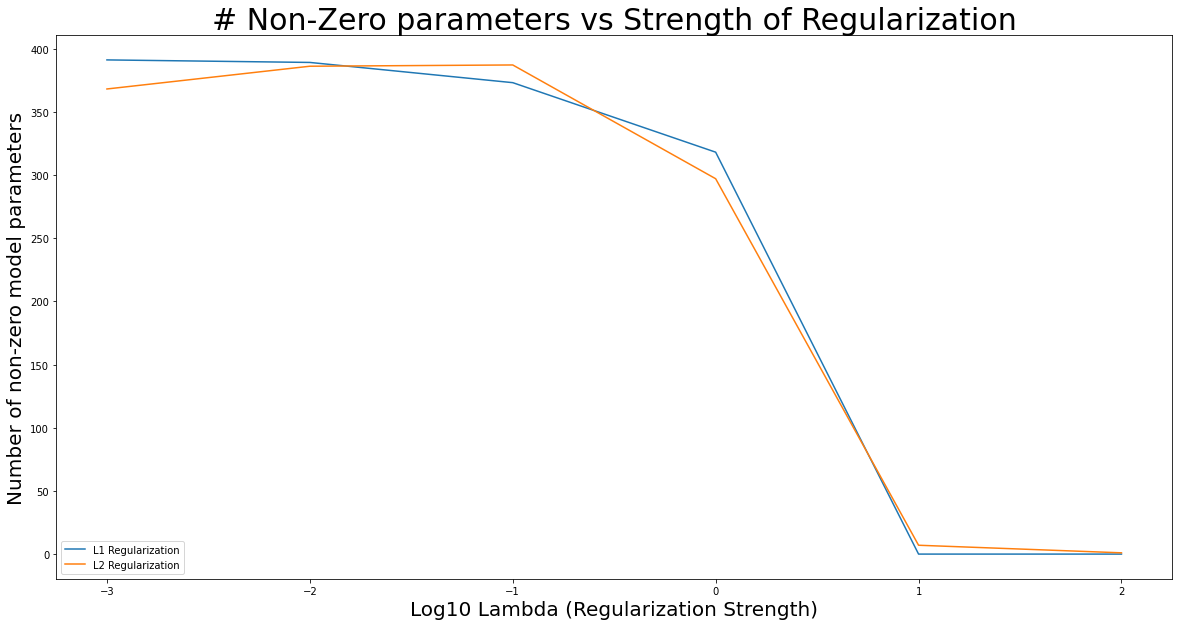

In [630]:
plt.figure(figsize=(20,10))
plt.xlabel("Log10 Lambda (Regularization Strength)", fontsize=20)
plt.ylabel("Number of non-zero model parameters", fontsize=20)
plt.title('# Non-Zero parameters vs Strength of Regularization', fontsize=30)
plt.plot(np.log10(np.array(lambdas)), non_zero_l1, label='L1 Regularization')
plt.plot(np.log10(np.array(lambdas)), non_zero_l2, label='L2 Regularization')
plt.legend(loc="lower left")


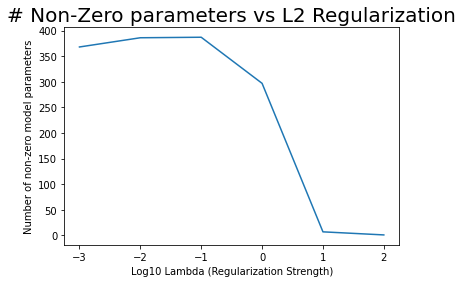

In [622]:
plt.xlabel("Log10 Lambda (Regularization Strength)", fontsize=10)
plt.ylabel("Number of non-zero model parameters", fontsize=10)
plt.title('# Non-Zero parameters vs L2 Regularization', fontsize=20)
plt.plot(np.log10(np.array(lambdas)), non_zero_l2)

# Q4-c

In [690]:
epsilon = .001
loss_func = 'squared'
reg = 'l1'
lr = 1e-5

gd_l1 = GradientDescent(loss=loss_func, regularization=reg, learning_rate=lr, reg_param=1)

In [691]:
gd_l1.fit(train_features, train_targets, max_iter=2000)

ITERATION 0
ITERATION 100
ITERATION 200
ITERATION 300
ITERATION 400
ITERATION 500
ITERATION 600
ITERATION 700
ITERATION 800
ITERATION 900
ITERATION 1000
ITERATION 1100
ITERATION 1200
ITERATION 1300
ITERATION 1400
ITERATION 1500
ITERATION 1600
ITERATION 1700
ITERATION 1800
ITERATION 1900


In [692]:
gd_l1.model.shape

(785,)

In [693]:
values = gd_l1.model[:-1]; values.shape

(784,)

In [694]:
non_zero_values = np.where(values < epsilon, 0, 1)

In [695]:
square_values = non_zero_values.reshape((28,28))

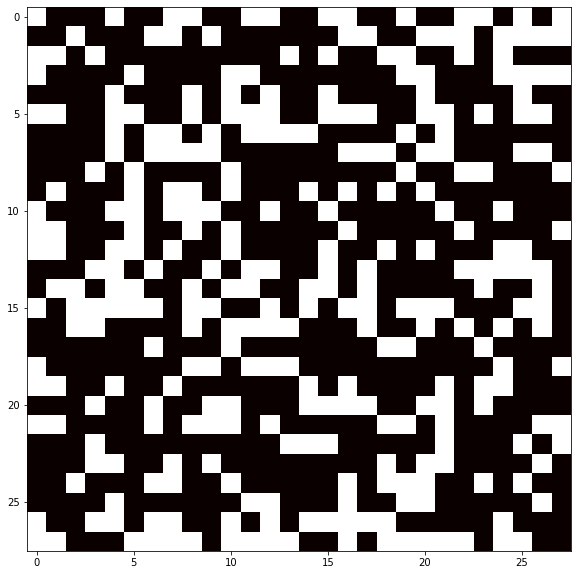

In [696]:
plt.figure(figsize=(20,10))
plt.imshow(square_values, cmap='hot')
plt.show()
 

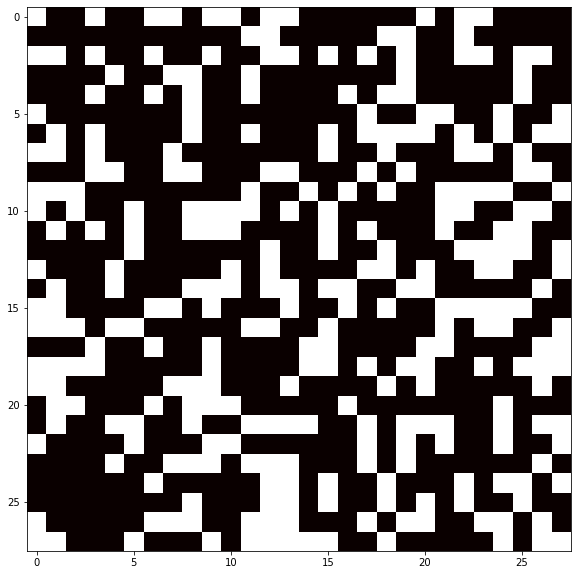

In [657]:
plt.figure(figsize=(20,10))
plt.imshow(square_values, cmap='hot')
plt.show()

# Q3 - a

In [586]:
train_features, test_features, train_targets, test_targets = load_data('mnist-multiclass', fraction=.75)

In [587]:
print(train_features.shape)
print(train_targets.shape)

(375, 784)
(375,)


In [588]:
print(test_features.shape)
print(test_targets.shape)

(125, 784)
(125,)


In [589]:
loss_func = 'squared'
reg = 'l1'

mgd = MultiClassGradientDescent(loss=loss_func, regularization=reg)

In [590]:
mgd.fit(train_features, train_targets)

ITERATION 0
ITERATION 100
ITERATION 200
ITERATION 0
ITERATION 100
ITERATION 0
ITERATION 100
ITERATION 200
ITERATION 0
ITERATION 100
ITERATION 200
ITERATION 0
ITERATION 100


In [593]:
pred = mgd.predict(test_features); pred

array([2, 1, 0, 4, 1, 4, 0, 0, 1, 3, 4, 4, 0, 4, 0, 1, 3, 1, 3, 0, 2, 1,
       1, 1, 1, 4, 1, 3, 3, 4, 4, 4, 3, 0, 4, 1, 3, 4, 4, 3, 0, 0, 2, 1,
       3, 2, 2, 4, 3, 1, 3, 3, 1, 4, 1, 0, 2, 2, 1, 4, 3, 4, 4, 4, 2, 4,
       0, 1, 0, 1, 4, 3, 1, 1, 2, 0, 4, 1, 0, 3, 4, 4, 4, 4, 1, 3, 0, 2,
       1, 1, 1, 0, 2, 0, 1, 0, 0, 4, 2, 3, 3, 2, 1, 0, 3, 2, 2, 2, 3, 3,
       2, 2, 2, 0, 0, 2, 1, 0, 3, 0, 0, 0, 0, 2, 3], dtype=int8)

In [594]:
confusion_matrix(test_targets, pred)

array([[24.,  0.,  1.,  0.,  0.],
       [ 0., 24.,  0.,  1.,  0.],
       [ 0.,  3., 19.,  1.,  2.],
       [ 2.,  1.,  0., 21.,  1.],
       [ 1.,  0.,  1.,  0., 23.]])

# Q2 - Part a

In [409]:
train_features, test_features, train_targets, test_targets = load_data('synthetic', fraction=1)

In [379]:
train_features

array([[0.],
       [1.],
       [2.],
       [3.],
       [4.],
       [5.]])

In [380]:
train_targets

array([-1, -1,  1,  1, -1,  1])

In [381]:
test_features

array([], shape=(1, 0), dtype=float64)

In [382]:
test_targets

array([], dtype=float64)

Using only the bias term, determine the 0-1 loss over the entire dataset by explicitly setting your bias values to 0.5, -0.5, -1.5, -2.5, -3.5, -4.5, and -5.5

In [419]:
biases = np.array([0.5, -0.5, -1.5, -2.5, -3.5, -4.5, -5.5])

In [384]:
train_features = np.append(train_features, np.ones(train_features.shape[0]).reshape(-1,1),  axis=1)

In [430]:
train_features.T.flatten()

array([0., 1., 2., 3., 4., 5.])

In [394]:
np.array([biases, np.ones(len(biases))])

array([[ 0.5, -0.5, -1.5, -2.5, -3.5, -4.5, -5.5],
       [ 1. ,  1. ,  1. ,  1. ,  1. ,  1. ,  1. ]])

In [448]:
g_x = np.zeros((7,6))

for ii in range(len(g_x)):
    g_x[ii] = (biases[ii]*np.ones(6).reshape(-1,1) + train_features).T.flatten()


In [449]:
g_x

array([[ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5],
       [-0.5,  0.5,  1.5,  2.5,  3.5,  4.5],
       [-1.5, -0.5,  0.5,  1.5,  2.5,  3.5],
       [-2.5, -1.5, -0.5,  0.5,  1.5,  2.5],
       [-3.5, -2.5, -1.5, -0.5,  0.5,  1.5],
       [-4.5, -3.5, -2.5, -1.5, -0.5,  0.5],
       [-5.5, -4.5, -3.5, -2.5, -1.5, -0.5]])

In [452]:
np.where(g_x[0] > 0, 1, -1)

array([1, 1, 1, 1, 1, 1])

In [454]:
h_x = np.zeros((7,6))

for ii in range(g_x.shape[0]):
    h_x[ii] = np.where(g_x[ii] > 0, 1, -1)

In [455]:
h_x

array([[ 1.,  1.,  1.,  1.,  1.,  1.],
       [-1.,  1.,  1.,  1.,  1.,  1.],
       [-1., -1.,  1.,  1.,  1.,  1.],
       [-1., -1., -1.,  1.,  1.,  1.],
       [-1., -1., -1., -1.,  1.,  1.],
       [-1., -1., -1., -1., -1.,  1.],
       [-1., -1., -1., -1., -1., -1.]])

In [459]:
zero_one_loss = np.zeros(7)

for ii in range(h_x.shape[0]):
    zero_one_loss[ii] = sum(np.where(h_x[ii] != train_targets, 1, 0))

In [460]:
zero_one_loss

array([3., 2., 1., 2., 3., 2., 3.])

In [463]:
biases

array([ 0.5, -0.5, -1.5, -2.5, -3.5, -4.5, -5.5])

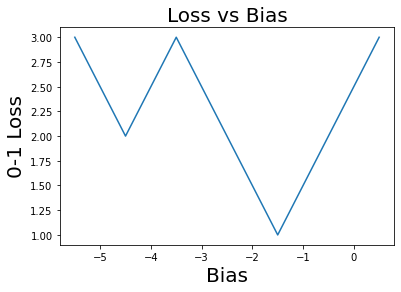

In [468]:
plt.xlabel("Bias", fontsize=20)
plt.ylabel("0-1 Loss", fontsize=20)
plt.title('Loss vs Bias', fontsize=20)
plt.plot(biases, zero_one_loss)

In [466]:
x = [1,0,0,-1,-1,-2,-2,-3,-3,-4,-4,-5,-5,-6]
y = [3,3,2,2,1,1,2,2,3,3,2,2,3,3]

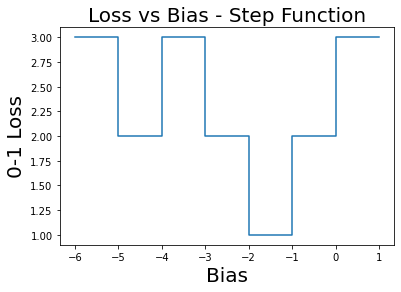

In [469]:
plt.xlabel("Bias", fontsize=20)
plt.ylabel("0-1 Loss", fontsize=20)
plt.title('Loss vs Bias - Step Function', fontsize=20)
plt.plot(x,y)

# Q2 - Part b 

In [494]:
print(train_features)
print(train_targets)

[[0.]
 [1.]
 [2.]
 [3.]
 [4.]
 [5.]]
[-1 -1  1  1 -1  1]


In [504]:
new_tf = train_features[:4]; new_tf

array([[0.],
       [1.],
       [2.],
       [3.]])

In [505]:
new_tt = train_targets[:4]; new_tt

array([-1, -1,  1,  1])

In [539]:
new_tf = np.array([0,1,4,5]).reshape(-1,1) ; 
new_tt = np.array([-1,-1,-1,1])
new_tf

array([[0],
       [1],
       [4],
       [5]])

In [540]:
g_x = np.zeros((7,4))

for ii in range(len(g_x)):
    g_x[ii] = (biases[ii]*np.ones(4).reshape(-1,1) + new_tf).T.flatten()


In [541]:
h_x = np.zeros((7,4))

for ii in range(g_x.shape[0]):
    h_x[ii] = np.where(g_x[ii] > 0, 1, -1)

In [542]:
zero_one_loss = np.zeros(7)

for ii in range(h_x.shape[0]):
    zero_one_loss[ii] = sum(np.where(h_x[ii] != new_tt, 1, 0))

In [543]:
g_x

array([[ 0.5,  1.5,  4.5,  5.5],
       [-0.5,  0.5,  3.5,  4.5],
       [-1.5, -0.5,  2.5,  3.5],
       [-2.5, -1.5,  1.5,  2.5],
       [-3.5, -2.5,  0.5,  1.5],
       [-4.5, -3.5, -0.5,  0.5],
       [-5.5, -4.5, -1.5, -0.5]])

In [544]:
h_x

array([[ 1.,  1.,  1.,  1.],
       [-1.,  1.,  1.,  1.],
       [-1., -1.,  1.,  1.],
       [-1., -1.,  1.,  1.],
       [-1., -1.,  1.,  1.],
       [-1., -1., -1.,  1.],
       [-1., -1., -1., -1.]])

In [545]:
zero_one_loss

array([3., 2., 1., 1., 1., 0., 1.])

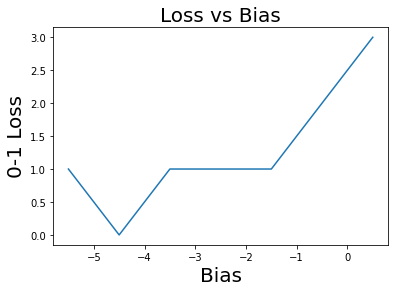

In [546]:
plt.xlabel("Bias", fontsize=20)
plt.ylabel("0-1 Loss", fontsize=20)
plt.title('Loss vs Bias', fontsize=20)
plt.plot(biases, zero_one_loss)

In [547]:
x = [1,0,0,-1,-1,-2,-3,-4,-4,-5,-5,-6]
y = [3,3,2,2,1,1,1,1,0,0,1,1]

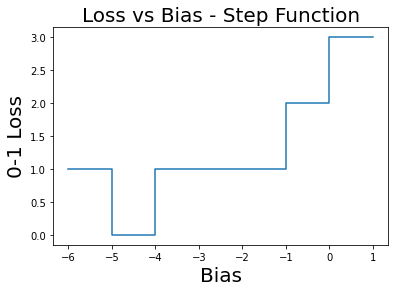

In [548]:
plt.xlabel("Bias", fontsize=20)
plt.ylabel("0-1 Loss", fontsize=20)
plt.title('Loss vs Bias - Step Function', fontsize=20)
plt.plot(x,y)

# Q1 - Part a

<AxesSubplot:title={'center':'Loss over Iterations'}, xlabel='Iterations', ylabel='Loss'>

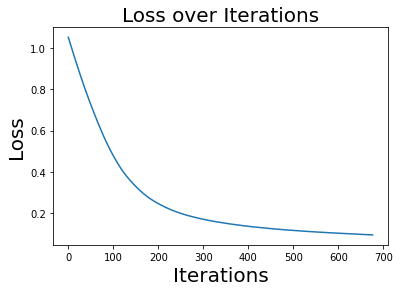

In [248]:
plt.xlabel("Iterations", fontsize=20)
plt.ylabel("Loss", fontsize=20)
plt.title('Loss over Iterations', fontsize=20)
# plt.plot(range(len(losses)), losses, "-", label="Degree 9, Lowest Train MSE")
sns.lineplot(x=range(len(losses)), y=losses)

<AxesSubplot:title={'center':'Accuracy over Iterations'}, xlabel='Iterations', ylabel='Accuracy'>

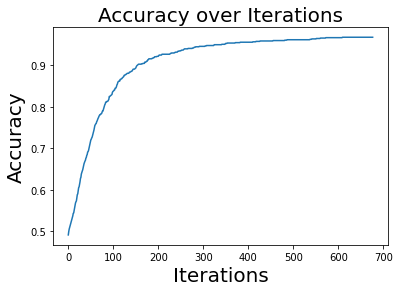

In [247]:
plt.xlabel("Iterations", fontsize=20)
plt.ylabel("Accuracy", fontsize=20)
plt.title('Accuracy over Iterations', fontsize=20)
# plt.plot(range(len(losses)), losses, "-", label="Degree 9, Lowest Train MSE")
sns.lineplot(x=range(len(accuracies)), y=accuracies)

# Q1 - Part b

In [339]:
lr = 1e-4
loss_func = 'hinge'

gd = GradientDescent(loss=loss_func, learning_rate=lr)

After each training iteration through the dataset (using batch gradient descent on just the training data), compute both the loss and accuracy of the model on the full training dataset.

In [340]:
losses, accuracies = gd.fit(train_mnist, train_digits, batch_size=1, max_iter = 1000 * 15)

ITERATION 0
ITERATION 1000
ITERATION 2000
ITERATION 3000
ITERATION 4000
ITERATION 5000
ITERATION 6000
ITERATION 7000
ITERATION 8000
ITERATION 9000
ITERATION 10000
ITERATION 11000
ITERATION 12000
ITERATION 13000
ITERATION 14000


<AxesSubplot:title={'center':'Loss over Iterations'}, xlabel='Iterations', ylabel='Loss'>

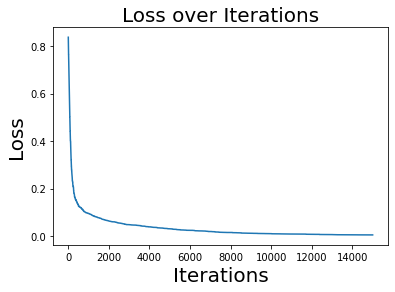

In [341]:
plt.xlabel("Iterations", fontsize=20)
plt.ylabel("Loss", fontsize=20)
plt.title('Loss over Iterations', fontsize=20)
# plt.plot(range(len(losses)), losses, "-", label="Degree 9, Lowest Train MSE")
sns.lineplot(x=range(len(losses)), y=losses)

<AxesSubplot:title={'center':'Accuracy over Iterations'}, xlabel='Iterations', ylabel='Accuracy'>

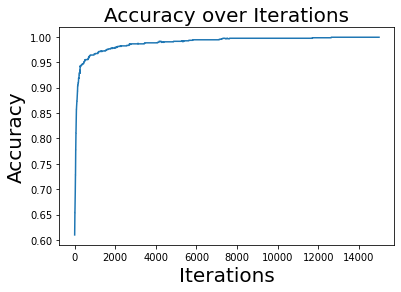

In [342]:
plt.xlabel("Iterations", fontsize=20)
plt.ylabel("Accuracy", fontsize=20)
plt.title('Accuracy over Iterations', fontsize=20)
# plt.plot(range(len(losses)), losses, "-", label="Degree 9, Lowest Train MSE")
sns.lineplot(x=range(len(accuracies)), y=accuracies)

In [343]:
losses_e = [losses[ii] for ii in range(len(losses)) if ii%1000==0]
acc_e = [accuracies[ii] for ii in range(len(accuracies)) if ii%1000==0]

<AxesSubplot:title={'center':'Loss over Iterations'}, xlabel='Iterations', ylabel='Loss'>

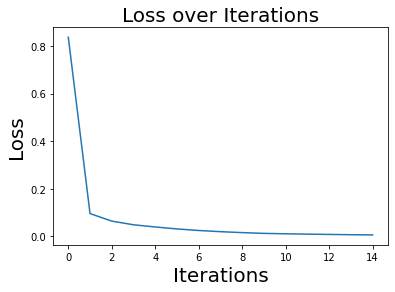

In [346]:
plt.xlabel("Iterations", fontsize=20)
plt.ylabel("Loss", fontsize=20)
plt.title('Loss over Iterations', fontsize=20)
# plt.plot(range(len(losses)), losses, "-", label="Degree 9, Lowest Train MSE")
sns.lineplot(x=range(len(losses_e)), y=losses_e)

<AxesSubplot:title={'center':'Accuracy over Iterations'}, xlabel='Iterations', ylabel='Accuracy'>

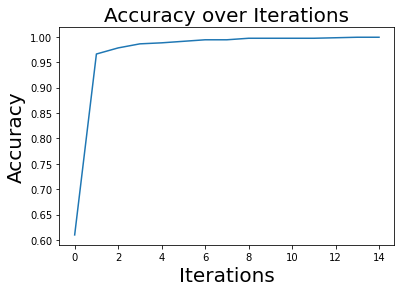

In [347]:
plt.xlabel("Iterations", fontsize=20)
plt.ylabel("Accuracy", fontsize=20)
plt.title('Accuracy over Iterations', fontsize=20)
# plt.plot(range(len(losses)), losses, "-", label="Degree 9, Lowest Train MSE")
sns.lineplot(x=range(len(acc_e)), y=acc_e)

In [374]:
lr = 1e-4
loss_func = 'hinge'

gd = GradientDescent(loss=loss_func, learning_rate=lr)

After each training iteration through the dataset (using batch gradient descent on just the training data), compute both the loss and accuracy of the model on the full training dataset.

In [375]:
losses_new, accuracies_new = gd.fit(train_mnist, train_digits, batch_size=1, max_iter = 1000 * 1000)

ITERATION 0


In [372]:
len(losses_new)

2

<AxesSubplot:title={'center':'Loss over Epochs'}, xlabel='Epochs', ylabel='Loss'>

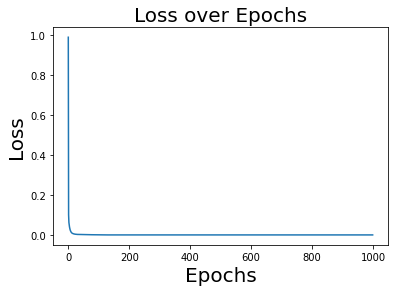

In [367]:
plt.xlabel("Epochs", fontsize=20)
plt.ylabel("Loss", fontsize=20)
plt.title('Loss over Epochs', fontsize=20)
# plt.plot(range(len(losses)), losses, "-", label="Degree 9, Lowest Train MSE")
sns.lineplot(x=range(len(losses_new)), y=losses_new)

<AxesSubplot:title={'center':'Accuracy over Epochs'}, xlabel='Epochs', ylabel='Accuracy'>

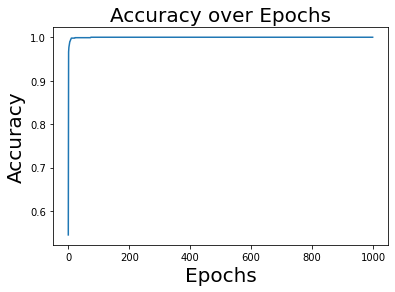

In [368]:
plt.xlabel("Epochs", fontsize=20)
plt.ylabel("Accuracy", fontsize=20)
plt.title('Accuracy over Epochs', fontsize=20)
# plt.plot(range(len(losses)), losses, "-", label="Degree 9, Lowest Train MSE")
sns.lineplot(x=range(len(accuracies_new)), y=accuracies_new)

In [363]:
losses_e_new = [losses_new[ii] for ii in range(len(losses_new)) if ii%1000==0]
acc_e_new = [accuracies_new[ii] for ii in range(len(accuracies_new)) if ii%1000==0]